# Mapping with `splot` and `PySAL`

### Imports

In [1]:
import libpysal.api as lp
from libpysal import examples
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

% matplotlib inline

### Data Preparation

Load example data into a `geopandas.GeoDataFrame` and inspect column names.

In [2]:
link_to_data = examples.get_path('Guerry.shp')
gdf = gpd.read_file(link_to_data)
gdf.columns

Index(['CODE_DE', 'COUNT', 'AVE_ID_', 'dept', 'Region', 'Dprtmnt', 'Crm_prs',
       'Crm_prp', 'Litercy', 'Donatns', 'Infants', 'Suicids', 'MainCty',
       'Wealth', 'Commerc', 'Clergy', 'Crm_prn', 'Infntcd', 'Dntn_cl',
       'Lottery', 'Desertn', 'Instrct', 'Prsttts', 'Distanc', 'Area',
       'Pop1831', 'geometry'],
      dtype='object')

Extract two arrays `x` and `y`. 

In [3]:
y = gdf['Donatns'].values
x = gdf['Suicids'].values

# Create different Choropleths using the `splot.mapping` functionality

In [4]:
from splot.mapping import vba_choropleth

Plot a value by alpha choropleth with `y` defining the rgb values and `x` defining the alpha value:

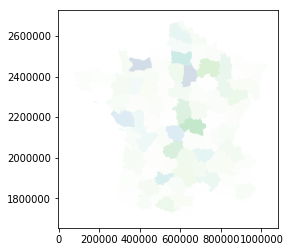

In [5]:
vba_choropleth(y, x, gdf)
plt.show()

You can use the option to bin or classify your `x` and `y` values. `splot` uses mapclassify to bin your data and displays the new color and alpha ranges:

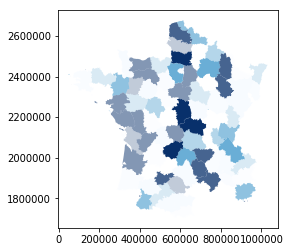

In [6]:
vba_choropleth(y, x, gdf, cmap='Blues',
               rgb_mapclassify=dict(classifier='quantiles', k=3), 
               alpha_mapclassify=dict(classifier='quantiles'))
plt.show()

Instead of using a colormap you can also pass a list of colors:

In [7]:
color_list = ['#a1dab4','#41b6c4','#225ea8']

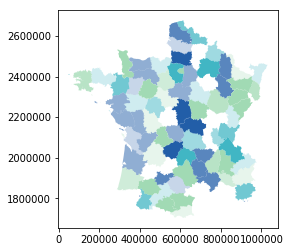

In [8]:
vba_choropleth(y, x, gdf, cmap=color_list,
               rgb_mapclassify=dict(classifier='quantiles', k=3), 
               alpha_mapclassify=dict(classifier='quantiles'))
plt.show()

You can use the `divergent` argument to display divergent alpha values. This means values at the extremes of your data range will be displayed with an alpha value of 1. Values towards the middle of your data range will be mapped more and more invisible towards an alpha value of 0.

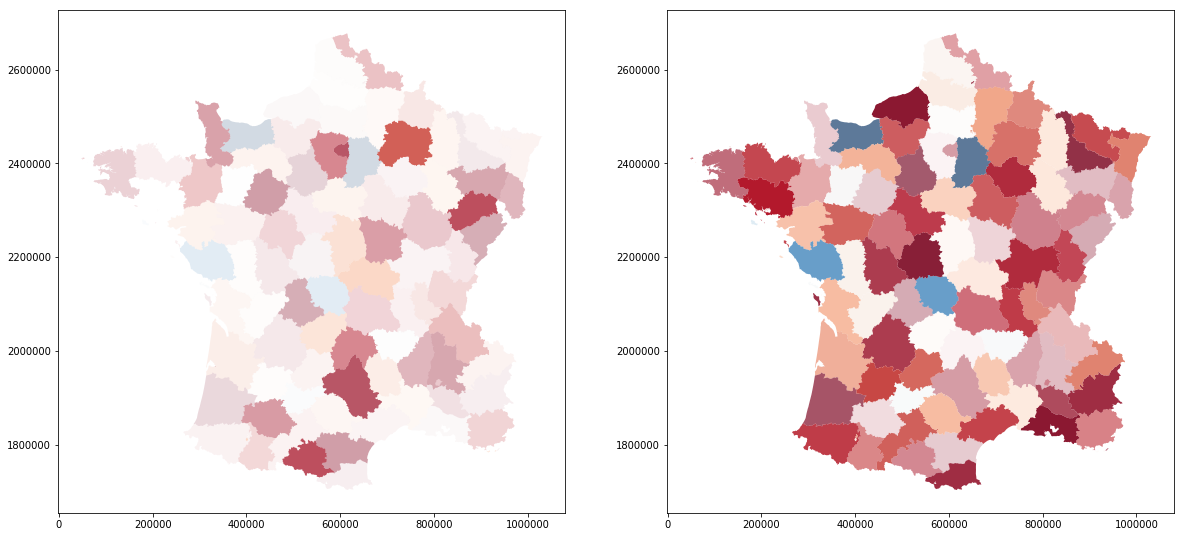

In [9]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
vba_choropleth(y, x, gdf, cmap='RdBu',
               divergent=False, ax=axs[0])
vba_choropleth(y, x, gdf, cmap='RdBu',
               divergent=True, ax=axs[1])
plt.show()

# Create your own cmap for plotting

Sometimes you need to display divergent values with a natural midpoint not overlapping wiht the median of your data. For example if you measure the temperature over a country ranging from -2 to 10 degrees Celsius. Or if you need to assess wether a certain threshold is reached.

For cases like this splot provides a utility function to shift your colormap.

In [10]:
from splot._viz_utils import shift_colormap

In [11]:
mid08 = shift_colormap('RdBu', midpoint=0.8)
mid02 = shift_colormap('RdBu', midpoint=0.2)

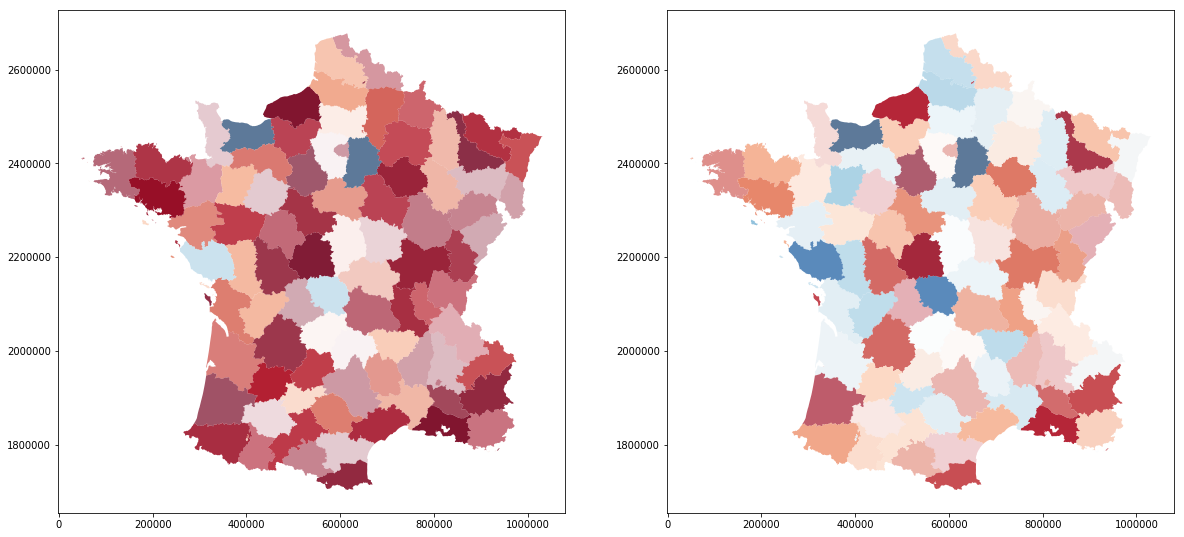

In [12]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
vba_choropleth(y, x, gdf, cmap=mid08, ax=axs[0], divergent=True)
vba_choropleth(y, x, gdf, cmap=mid02, ax=axs[1], divergent=True)
plt.show()

# EXAMPLE: US elections

### Data Preparation

In [13]:
shp_link = examples.get_path("NAT.shp")

In [14]:
# get shape file
df = gpd.read_file(shp_link)
# and read csv directly from link
vote_table = pd.read_csv("https://gist.github.com/ljwolf/bfc78bdb34f87d741f705eda68793da3/raw/e3a93531fe074ef8a9b322008f24f7fdc9f4ffad/US_County_Level_Presidential_Results_08-16.csv")

In [15]:
df.shape

(3085, 70)

In [16]:
# calculate two-part vote share dem / (dem + repub)
years = [2008, 2012, 2016]
for year in years:
    vote_table[str(year)+'2p_voteshare'] = vote_table["dem_"+str(year)] / (vote_table["dem_"+str(year)] + vote_table["gop_"+str(year)])

In [17]:
# calculate total count
for year in years:
    vote_table[str(year)+"total_counts"] = vote_table["dem_"+str(year)] + vote_table["gop_"+str(year)]

In [18]:
vote_table.shape

(3112, 20)

In [19]:
vote_table.head()

,fips_code,county,total_2008,dem_2008,gop_2008,oth_2008,total_2012,dem_2012,gop_2012,oth_2012,total_2016,dem_2016,gop_2016,oth_2016,20082p_voteshare,20122p_voteshare,20162p_voteshare,2008total_counts,2012total_counts,2016total_counts
0,26041,Delta County,19064,9974,8763,327,18043,8330,9533,180,18467,6431,11112,924,0.532316,0.466327,0.366585,18737,17863,17543
1,48295,Lipscomb County,1256,155,1093,8,1168,119,1044,5,1322,135,1159,28,0.124199,0.102322,0.104328,1248,1163,1294
2,1127,Walker County,28652,7420,20722,510,28497,6551,21633,313,29243,4486,24208,549,0.263663,0.232437,0.156339,28142,28184,28694
3,48389,Reeves County,3077,1606,1445,26,2867,1649,1185,33,3184,1659,1417,108,0.526385,0.581863,0.539337,3051,2834,3076
4,56017,Hot Springs County,2546,619,1834,93,2495,523,1894,78,2535,400,1939,196,0.252344,0.216384,0.171013,2453,2417,2339


In [20]:
# merge
gdf = df.merge(vote_table, left_on='FIPSNO', right_on='fips_code')

# test implication of different shapes and which data is missing
for fips in df['FIPSNO']:
    if not np.any(fips == gdf['fips_code']):
        print('Missing: ', fips)
        print(df[df['FIPSNO'] == fips].head())
        
        
gdf[gdf['NAME'] == 'Clifton Forge']

Missing:  51560
               NAME STATE_NAME STATE_FIPS CNTY_FIPS   FIPS  STFIPS  COFIPS  \
1522  Clifton Forge   Virginia         51       560  51560      51     560   

      FIPSNO  SOUTH  HR60                        ...                          \
1522   51560      1   0.0                        ...                           

          BLK90      GI59      GI69      GI79      GI89       FH60  FH70  \
1522  14.853601  0.280873  0.338203  0.351892  0.409826  16.401734  13.9   

           FH80      FH90                                           geometry  
1522  11.485452  19.02131  POLYGON ((-79.80414581298828 37.81179428100586...  

[1 rows x 70 columns]
Missing:  12025
      NAME STATE_NAME STATE_FIPS CNTY_FIPS   FIPS  STFIPS  COFIPS  FIPSNO  \
2889  Dade    Florida         12       025  12025      12      25   12025   

      SOUTH       HR60                        ...                          \
2889      1  10.516405                        ...                           

      

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,total_2016,dem_2016,gop_2016,oth_2016,20082p_voteshare,20122p_voteshare,20162p_voteshare,2008total_counts,2012total_counts,2016total_counts


### Extract data to be plotted and plot

In [21]:
x = gdf['20162p_voteshare'].values
y = gdf['2016total_counts'].values

In [22]:
import splot
from splot.mapping import vba_choropleth, value_by_alpha_cmap

In [23]:
from splot._viz_utils import shift_colormap, truncate_colormap

In [24]:
cmap = plt.cm.seismic
new_cmap = shift_colormap(cmap, start=0, midpoint=0.2, stop=1)

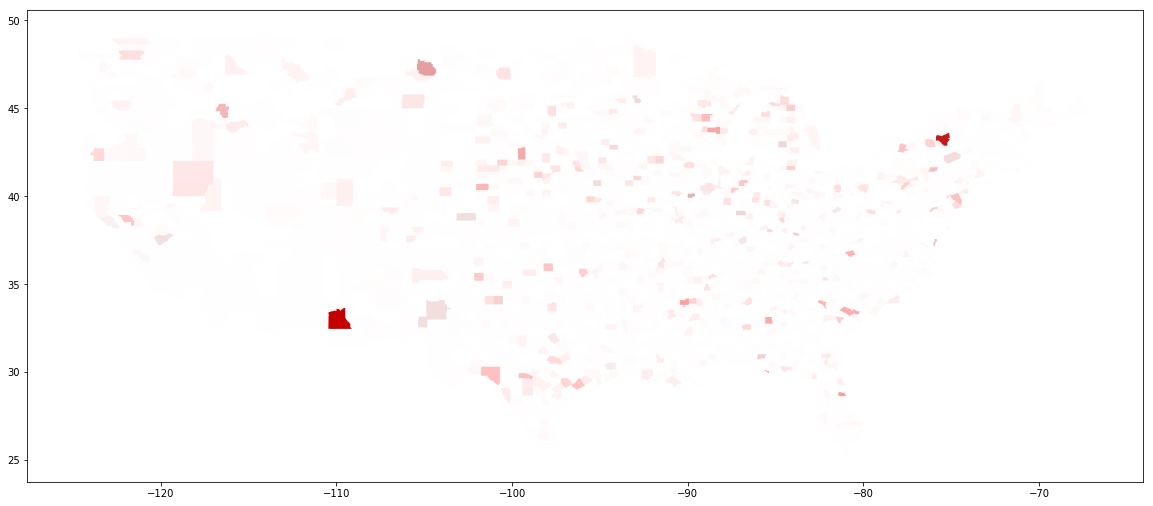

In [25]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
vba_choropleth(x, y, gdf, cmap=new_cmap, ax=ax, divergent=False)
plt.show()

In [26]:
rgba = value_by_alpha_cmap(x, y, cmap=new_cmap, divergent=True)

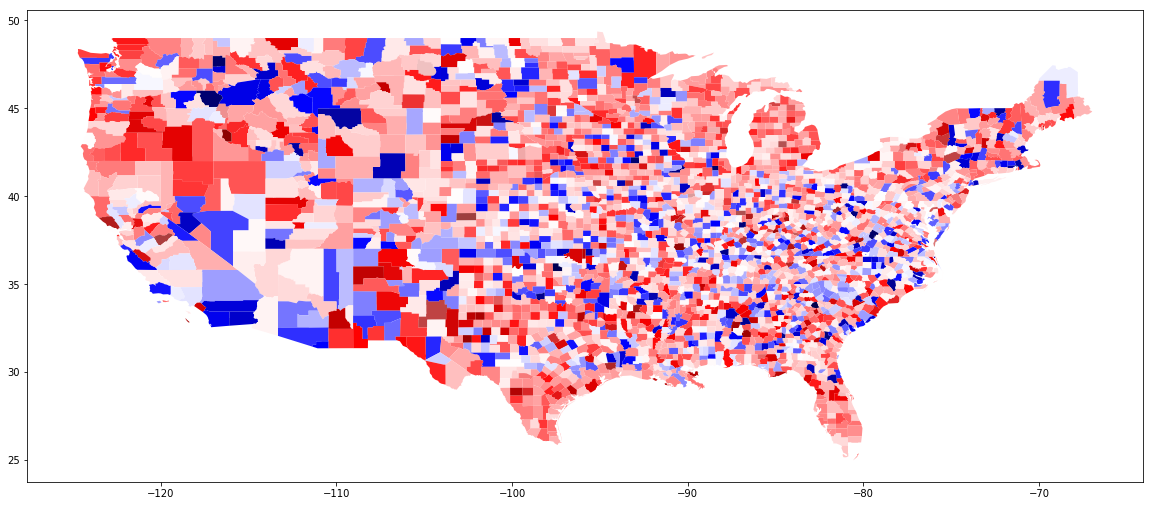

In [27]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
gdf.plot(color= rgba, ax=ax)
plt.show()

In [28]:
import mapclassify

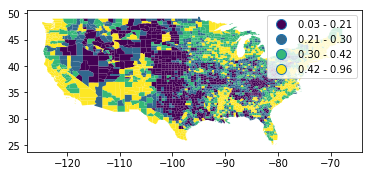

In [29]:
gdf.plot(column='20162p_voteshare', scheme='quantiles', k=4, legend=True)

In [30]:
from splot._viz_value_by_alpha_mpl import mapclassify_bin

In [31]:
alpha_bins = mapclassify_bin(y, classifier='quantiles', k=4)
alpha_bins

                     Quantiles                     
 
   Lower                Upper                 Count
              x[i] <=    4581.000               771
   4581.000 < x[i] <=   10386.000               771
  10386.000 < x[i] <=   26658.500               770
  26658.500 < x[i] <= 2197217.000               771

In [32]:
rgb_bins = mapclassify_bin(x, classifier='quantiles', k=4)
rgb_bins

               Quantiles               
 
Lower          Upper              Count
        x[i] <= 0.213               771
0.213 < x[i] <= 0.297               771
0.297 < x[i] <= 0.418               770
0.418 < x[i] <= 0.957               771

In [33]:
values_y = alpha_bins.yb
values_y

array([0, 0, 2, ..., 3, 3, 3])

In [34]:
values_x = np.array(rgb_bins.yb)

In [35]:
new_rgba=value_by_alpha_cmap(values_x, values_y, divergent = True, cmap='RdBu')

In [36]:
new_rgba


array([[0.96862745, 0.71764706, 0.6       , 1.        ],
       [0.65490196, 0.81437908, 0.89411765, 1.        ],
       [0.96862745, 0.71764706, 0.6       , 0.33333333],
       ...,
       [0.65490196, 0.81437908, 0.89411765, 1.        ],
       [0.01960784, 0.18823529, 0.38039216, 1.        ],
       [0.01960784, 0.18823529, 0.38039216, 1.        ]])

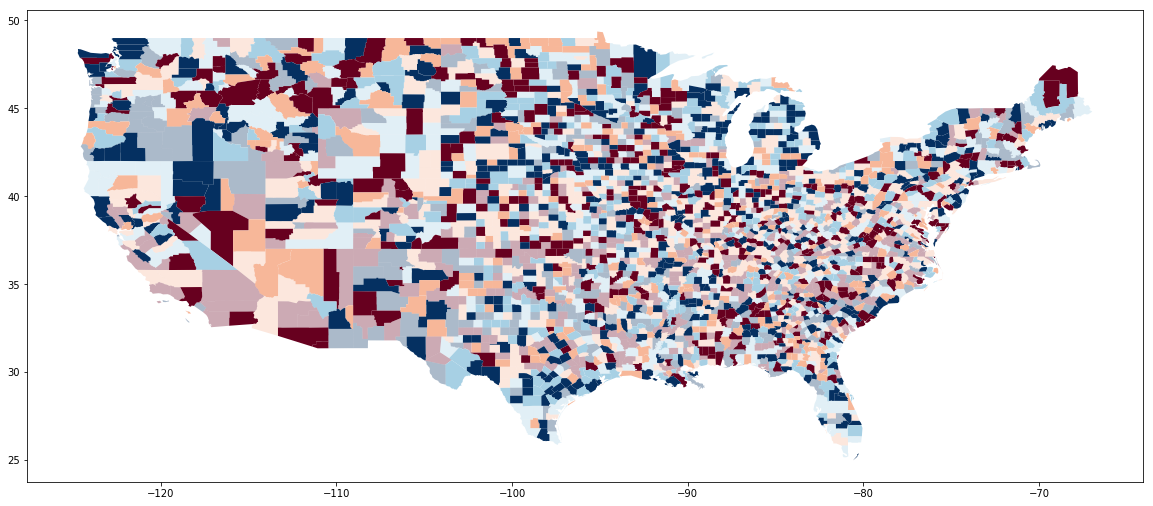

In [37]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
gdf.plot(color= new_rgba, ax=ax)
plt.show()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126381400>)

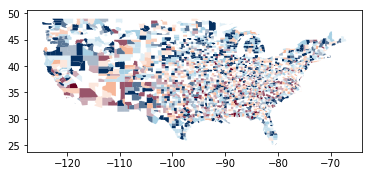

In [38]:
vba_choropleth(values_x, values_y, gdf, cmap='RdBu', divergent=False)